In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: module://matplotlib_inline.backend_inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
import os
import pandas as pd
from pathlib import Path

In [3]:
def read_tomst(csv):

    df = pd.read_csv(csv, 
                     sep=';', 
                     names=['idx', 'date', 'loc', 't1', 't2', 't3', 'sm', 'shake', 'err', ],
                     on_bad_lines='warn', 
                     usecols=range(9))
    df.date = pd.to_datetime(df.date, format="%Y.%m.%d %H:%M")
    df.sort_values('date', inplace=True)
    df['c_sm'] = -0.000000019 * df.sm**2 + 0.000265610 * df.sm - 0.154089291

    return df

In [ ]:
# >>> enter path to csv directory below <<<
root_directory = r'C:\path\to\soil_moisture_sensor_dir'
plot_temp = True # True plots temperature on the same fig

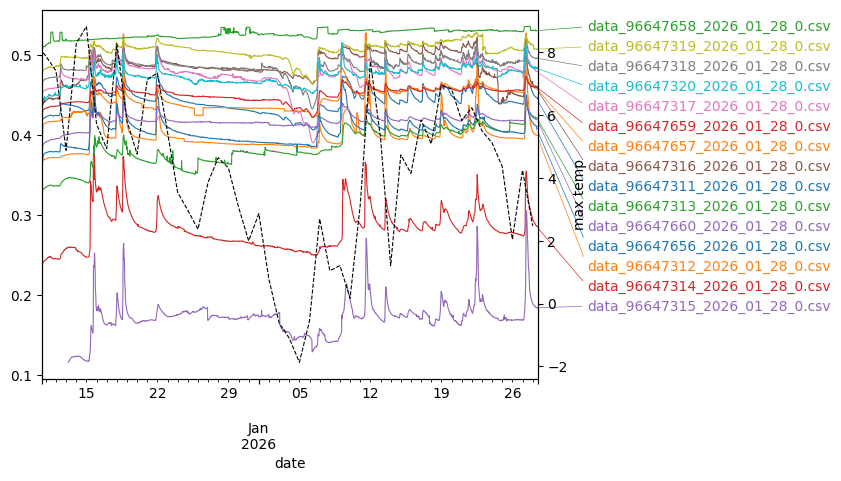

In [11]:
# run this to plot data
ax = plt.subplot()
root = Path(root_directory)

lbl_loc = {}

for i, csv in enumerate(root.rglob('data_*.csv')):
    tmt = read_tomst(csv)
    tmt = tmt.loc[tmt.sm > 1100]
    # print(csv, tmt.sm.max(), tmt.date.max())
    tmt.plot('date', 'c_sm', ax=ax, c=f'C{i}', legend=None, lw=.8) # plot calibrated soil moisture
    lbl_loc[os.path.split(str(csv))[1]] = [tmt.iloc[-1].c_sm.item(), f'C{i}']
    if plot_temp and i == 0:
        ax2 = ax.twinx()
        tmp = tmt.set_index('date')
        tmp = tmp.resample('D').t3.mean()
        tmp.plot(ax=ax2, legend=None, c='k', ls='--', lw=.8)
        ax2.set_ylabel('mean temp')
        
lbl_loc = pd.DataFrame.from_dict(lbl_loc, orient="index", columns=["value", "color"])
lbl_loc = lbl_loc.reset_index(names='filename')
lbl_loc = lbl_loc.sort_values('value', ascending=False).reset_index(drop=True)
lbl_loc['y_offset'] = lbl_loc.iloc[0].value - (lbl_loc.index.values * .025)
xpos = ax.get_xlim()[0] + (1.1 * (ax.get_xlim()[1] - ax.get_xlim()[0]))

for row in lbl_loc.itertuples():
    ax.annotate(row.filename, xy=(tmt.iloc[-1].date, row.value), xytext=((xpos, row.y_offset)), 
                c=row.color, 
                arrowprops={'color':row.color, 'linewidth':.5, 'arrowstyle':'-', 'relpos':(0, .5)}
               )
